In [17]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import TensorBoard, ModelCheckpoint

# from google.colab import drive
# drive.mount("/content/gdrive")

In [18]:
import keras
print(keras.__version__)

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

2.2.4
['/job:localhost/replica:0/task:0/device:GPU:0']


In [19]:
drive_base_path = "../"
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
path_to_balanced_images = drive_base_path + "dataset/Balanced_Training_Input_Aug/"

In [20]:
NAME = "VGG16_%s" % (int(time.time()))
tensorboard = TensorBoard(log_dir='./logs/%s' % (NAME))

In [21]:
filepath = drive_base_path + "models/checkpoint/VGG16.{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [22]:
def load_sample(path_to_images, number_of_images):
    list_of_images = os.listdir(path_to_images)
    x = []
    for i, filename in enumerate(list_of_images):
        image = cv2.imread(path_to_images + filename)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x.append(image)
        
        if i >= number_of_images:
            break
    
    x = np.array(x)
    return x       

In [23]:
x = load_sample(path_to_images, 1000)
print(x.shape)

(1001, 450, 600, 3)


In [6]:
datagen = ImageDataGenerator(
    featurewise_center=True,
#     featurewise_std_normalization=True,
    rotation_range=30,
    zoom_range=0.2,
    fill_mode='constant',
    cval=0,
    validation_split=0.1,
    data_format="channels_last")

In [7]:
datagen.fit(x)

In [8]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
batch_size = 16
train_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=batch_size,
                    classes=classes,
                    shuffle=True,
                    subset='training')

validation_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=batch_size,
                    classes=classes,
                    shuffle=True,
                    subset='validation')

Found 29871 images belonging to 7 classes.
Found 3317 images belonging to 7 classes.


In [9]:
train_samples = train_generator.samples
valid_samples = validation_generator.samples

In [10]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

print(class_weights)

[1.06495775 0.7070896  1.08196899 1.11533866 1.07841438 1.03074534
 1.07705344]


# DEFINING THE MODEL

In [11]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

model.compile(loss="categorical_crossentropy", 
              optimizer=RMSprop(lr=1e-5), 
              metrics=["acc"])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
epochs = 6
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_samples / batch_size,
                              validation_data=validation_generator,
                              validation_steps=valid_samples / batch_size,
                              epochs=epochs,
#                               class_weight=class_weights,
                              verbose=1,
                              callbacks=[tensorboard, checkpoint])

Epoch 1/6
1867/1866 [==============================] - 547s 293ms/step - loss: 5.4989 - acc: 0.3572 - val_loss: 1.8003 - val_acc: 0.5194

Epoch 00001: val_acc improved from -inf to 0.51945, saving model to ../models/checkpoint/VGG16.01-0.52.hdf5
Epoch 2/6
1867/1866 [==============================] - 542s 290ms/step - loss: 2.4880 - acc: 0.4567 - val_loss: 1.3471 - val_acc: 0.5626

Epoch 00002: val_acc improved from 0.51945 to 0.56256, saving model to ../models/checkpoint/VGG16.02-0.56.hdf5
Epoch 3/6
 492/1866 [======>.......................] - ETA: 6:03 - loss: 1.8185 - acc: 0.4962

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1867/1866 [==============================] - 542s 290ms/step - loss: 1.2547 - acc: 0.5883 - val_loss: 1.2273 - val_acc: 0.6081

Epoch 00006: val_acc improved from 0.60205 to 0.60808, saving model to ../models/checkpoint/VGG16.06-0.61.hdf5


### Load model from checkpoint

In [15]:
filepath = drive_base_path + "models/checkpoint/VGG16.06-0.61.hdf5"
model = load_model(filepath)

In [16]:
epochs = 4
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_samples / batch_size,
                              validation_data=validation_generator,
                              validation_steps=valid_samples / batch_size,
                              epochs=epochs,
#                               class_weight=class_weights,
                              verbose=1,
                              callbacks=[tensorboard, checkpoint])

Epoch 1/4
1867/1866 [==============================] - 542s 290ms/step - loss: 1.1849 - acc: 0.6109 - val_loss: 1.1408 - val_acc: 0.6192

Epoch 00001: val_acc improved from 0.60808 to 0.61923, saving model to ../models/checkpoint/VGG16.01-0.62.hdf5
Epoch 2/4
1867/1866 [==============================] - 543s 291ms/step - loss: 1.1523 - acc: 0.6272 - val_loss: 1.2240 - val_acc: 0.6192

Epoch 00002: val_acc did not improve from 0.61923
Epoch 3/4
1867/1866 [==============================] - 542s 291ms/step - loss: 1.1023 - acc: 0.6414 - val_loss: 1.2543 - val_acc: 0.6186

Epoch 00003: val_acc did not improve from 0.61923
Epoch 4/4
1867/1866 [==============================] - 542s 290ms/step - loss: 1.0877 - acc: 0.6478 - val_loss: 1.3107 - val_acc: 0.6045

Epoch 00004: val_acc did not improve from 0.61923


In [17]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

for layer in model.layers[:11]:
    layer.trainable = False
for layer in model.layers[11:]:
    layer.trainable = True

# for layer in model.layers:
#     print(layer, layer.trainable)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten_1
20 dense_1
21 dropout_1
22 dense_2
23 dropout_2
24 dense_3


In [12]:
filepath = drive_base_path + "models/checkpoint/VGG16.01-0.62.hdf5"
model = load_model(filepath)

In [14]:
filepath = drive_base_path + "models/checkpoint/VGG_REST.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [15]:
NAME = "VGG16_REST_%s" % (int(time.time()))
tensorboard = TensorBoard(log_dir='./logs/%s' % (NAME))

In [16]:
model.compile(optimizer=SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=["acc"])
epochs = 15
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_samples / batch_size,
                              validation_data=validation_generator,
                              validation_steps=valid_samples / batch_size,
#                               class_weight=class_weights,
                              epochs=epochs,
                              verbose=1,
                              callbacks=[tensorboard, checkpoint])
model.save_weights(drive_base_path + 'models/VGG16_AUG_ISIC_cnn.h5')
# model.evaluate(X_test, y_test)

Epoch 1/15
1867/1866 [==============================] - 504s 270ms/step - loss: 1.4248 - acc: 0.5120 - val_loss: 1.2253 - val_acc: 0.5574

Epoch 00001: val_acc improved from -inf to 0.55743, saving model to ../models/checkpoint/VGG_REST.01-1.23.hdf5
Epoch 2/15
1867/1866 [==============================] - 499s 267ms/step - loss: 1.2537 - acc: 0.5349 - val_loss: 1.1593 - val_acc: 0.5577

Epoch 00002: val_acc improved from 0.55743 to 0.55773, saving model to ../models/checkpoint/VGG_REST.02-1.16.hdf5
Epoch 3/15
1867/1866 [==============================] - 500s 268ms/step - loss: 1.1640 - acc: 0.5606 - val_loss: 1.1263 - val_acc: 0.5800

Epoch 00003: val_acc improved from 0.55773 to 0.58004, saving model to ../models/checkpoint/VGG_REST.03-1.13.hdf5
Epoch 4/15
1867/1866 [==============================] - 497s 266ms/step - loss: 1.0997 - acc: 0.5861 - val_loss: 1.1164 - val_acc: 0.5752

Epoch 00004: val_acc did not improve from 0.58004
Epoch 5/15
1867/1866 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1867/1866 [==============================] - 499s 267ms/step - loss: 0.9604 - acc: 0.6324 - val_loss: 1.0709 - val_acc: 0.6108

Epoch 00007: val_acc did not improve from 0.61381
Epoch 8/15
1867/1866 [==============================] - 499s 267ms/step - loss: 0.9352 - acc: 0.6404 - val_loss: 1.0651 - val_acc: 0.6105

Epoch 00008: val_acc did not improve from 0.61381
Epoch 9/15
1867/1866 [==============================] - 498s 267ms/step - loss: 0.9000 - acc: 0.6527 - val_loss: 1.0617 - val_acc: 0.6277

Epoch 00009: val_acc improved from 0.61381 to 0.62768, saving model to ../models/checkpoint/VGG_REST.09-1.06.hdf5
Epoch 10/15
1867/1866 [==============================] - 499s 267ms/step - loss: 0.8868 - acc: 0.6591 - val_loss: 1.0575 - val_acc: 0.6322

Epoch 00010: val_acc improved from 0.62768 to 0.63220, saving model to ../models/checkpoint/VGG_REST.10-1.06.hdf5
Epoch 11/15
1867/1866 [==============================] - 499s 267ms/step - loss: 0.8561 - acc: 0.6729 - val_loss: 1.1274 - val

# ACCURACY AND LOSS PLOTS

In [1]:
# Plot Training and Validation Accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

# CONFUSION MATRIX

In [ ]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
validation_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=1,
                    classes=classes,
                    shuffle=False,
                    subset='validation')

In [ ]:
filepath = drive_base_path + "models/checkpoint/VGG16_REST.14-1.38.hdf5"
model.load_weights(filepath)

In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Y_pred = model.predict_generator(validation_generator, steps=valid_samples / 1)
y_pred = np.argmax(Y_pred, axis=1)

Found 32404 images belonging to 7 classes.


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
plot_confusion_matrix(validation_generator.classes, y_pred, classes=class_names, title='Confusion matrix')
plt.show()

# ISIC LIVE IMAGE TEST/VALIDATION DATA

In [5]:
# TESTTING ON ISIC LIVE IMAGE DATA
path_to_images = drive_base_path + "dataset/ISIC2018_Task3_Test_Input/"

In [6]:
def preprocess_images(path_to_images):
    images_list = []
    filename_list = []
    
    path_to_images = path_to_images + 'test/'
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        filename_list.append(filename[:-4])
        
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2] # height, width

        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        image = cv2.resize(image, (new_size[1], new_size[0]))
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)

        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, 
                                    value=color)

        images_list.append(new_img)
        
    images_list = np.array(images_list)
    filename_list = np.array(filename_list)
    filename_list = filename_list[:, None]
    return (images_list, filename_list)

In [7]:
x_test, names = preprocess_images(path_to_images)

(1512, 224, 224, 3)
(1512, 1)


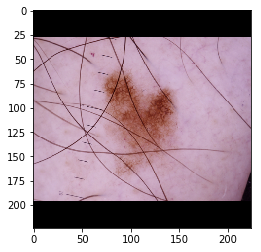

In [8]:
print(x_test.shape)
print(names.shape)
plt.imshow(x_test[5])

In [9]:
datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    data_format="channels_last")

In [10]:
datagen.fit(x_test)

In [11]:
test_generator = datagen.flow(
                    x_test,
                    batch_size=1,
                    shuffle=False)

In [12]:
model.load_weights(drive_base_path + 'models/VGG16_AUG_ISIC_cnn.h5')

In [ ]:
predictions = model.predict_generator(test_generator, steps=len(x_test))
# classes = (predictions > 0.5).astype(np.float)
# print(classes.shape)

In [ ]:
print(predictions.shape)

In [31]:
final_output = np.concatenate((names, predictions), axis=1)
final_output.shape

(1512, 8)

In [32]:
import csv

with open(drive_base_path + "output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
    writer.writerows(final_output)